# Problem Statement:

Skin cancer is one of the most common cancers globally, with melanoma being the deadliest form. Despite accounting for only a small percentage of skin cancer cases, melanoma is responsible for 75% of skin cancer-related deaths. Early detection of melanoma can significantly improve survival rates. However, the manual evaluation of skin lesion images by dermatologists is time-consuming and prone to human error.

The goal of this assignment is to build a custom Convolutional Neural Network (CNN) model in TensorFlow to accurately classify skin lesions into nine distinct categories. This automated solution has the potential to assist dermatologists by reducing the manual effort required for diagnosis, thereby enabling quicker and more accurate detection of melanoma and other skin conditions.

# Dataset Overview
The dataset contains 2,357 dermatoscopic images of malignant and benign oncological diseases, sourced from the International Skin Imaging Collaboration (ISIC). The dataset is categorized into the following nine classes:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion




The dataset is imbalanced, with some classes, such as melanomas and moles (nevus), having a higher representation. Addressing this imbalance is a critical part of the project.

# Objectives
- Develop a robust CNN model capable of accurately classifying skin lesion images.
- Handle data imbalances effectively to improve model performance across all classes.
- Evaluate and refine the model to ensure high accuracy and reliability without overfitting or underfitting.
- Provide insights into the dataset and the model's decision-making process.


By completing this project, we aim to create a reliable and scalable solution for the early detection of melanoma, which could potentially assist dermatologists in saving lives.

### Importing Required Libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import zipfile

In [2]:
# Path to the zip file
zip_file_path = 'CNN_assignment.zip'

# Extract the zip file into a directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('Cancer_data')

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Cancer_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Cancer_data/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [89]:
# Using 80% of the images for training, and 20% for validation.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Reserve 20% of data for validation
    subset="training",     # Specify this subset as training data
    seed=123,              # Ensure reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)



Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [88]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Use the same split for validation
    subset="validation",   # Specify this subset as validation data
    seed=123,              # Ensure reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualizing the Data

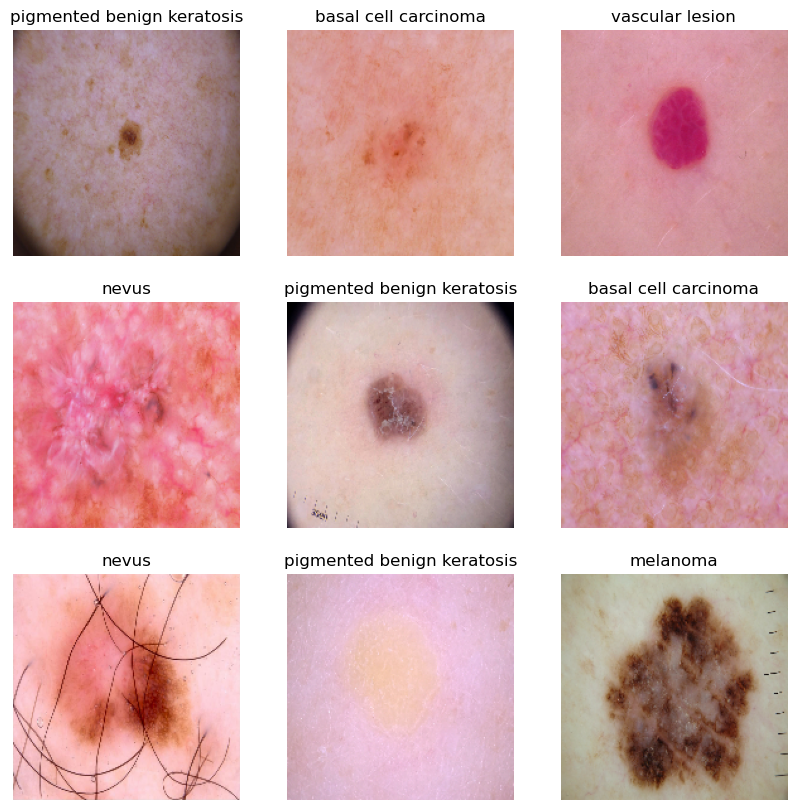

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Creation and Compiling

Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [15]:
# Create the CNN model
model = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),

    # Convolutional layer 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional layer 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional layer 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flattening the feature map
    layers.Flatten(),

    # Fully connected layer 1
    layers.Dense(128, activation='relu'),
    # Dropout for regularization

    # Output layer with softmax activation
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

C:\Users\ramya\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#  Training the Model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 640ms/step - accuracy: 0.2223 - loss: 2.1966 - val_accuracy: 0.3445 - val_loss: 1.8361
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 610ms/step - accuracy: 0.4068 - loss: 1.7265 - val_accuracy: 0.4922 - val_loss: 1.5113
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 607ms/step - accuracy: 0.5080 - loss: 1.4269 - val_accuracy: 0.4653 - val_loss: 1.5818
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 605ms/step - accuracy: 0.5330 - loss: 1.3803 - val_accuracy: 0.5011 - val_loss: 1.4234
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 601ms/step - accuracy: 0.5484 - loss: 1.2761 - val_accuracy: 0.5503 - val_loss: 1.4335
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5756 - loss: 1.2108 - val_accuracy: 0.5190 - val_loss: 1.3859
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 594ms/step - accuracy: 0.6076 - loss: 1.1199 - val_accuracy: 0.5257 - val_loss: 1.3983
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 620ms/step - accuracy: 0.6218 - loss: 1.0949 - val_accura

### Insights:
- 1. Training accuracy increased from 22.23% to 85.19%.
- 2. Validation accuracy fluctuated between 34.45% and 53.02%, showing inconsistent performance.
- 3. Validation loss fluctuated between 1.84 and 2.54, indicating instability in model generalization.
 
### Reasons 
    1. Overfitting: The large gap between training and validation accuracy suggests overfitting.
        Solution: Implement dropout, L2 regularization, or early stopping.


In [ ]:
# Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Creating Model with Augmentation¶

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height, img_width, 3)),  # Randomly flip images horizontally or vertically
    layers.RandomRotation(0.2),  # Rotate images by up to 20%
    layers.RandomZoom(0.2),      # Zoom in or out on images
    layers.RandomContrast(0.2),  # Adjust contrast
    layers.RandomTranslation(0.1, 0.1)
])

C:\Users\ramya\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


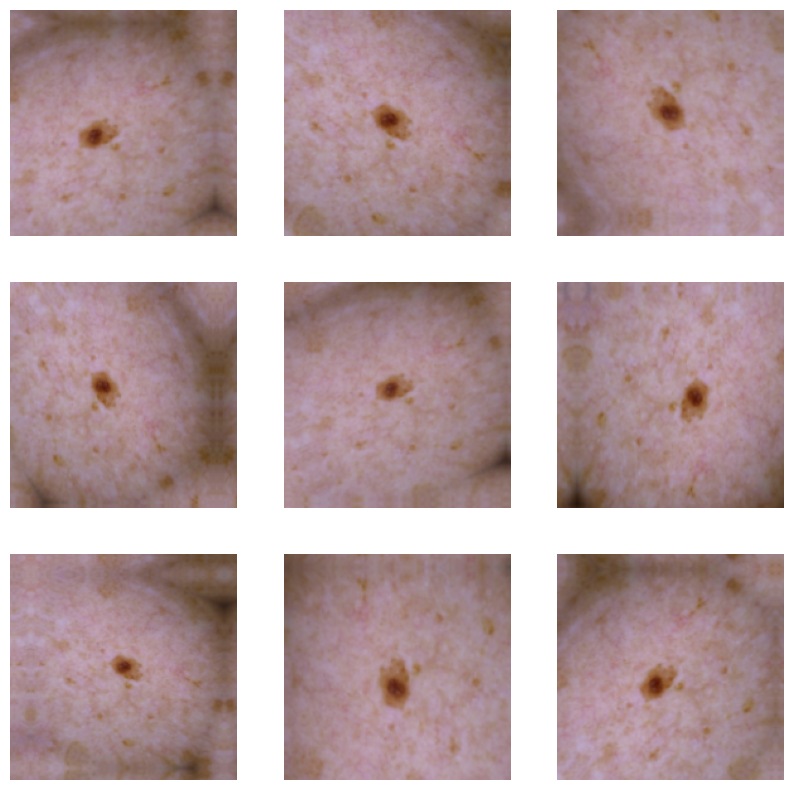

In [18]:
plt.figure(figsize=(10,10))
for imgae, _ in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")


In [19]:
model_with_augmentation = Sequential([
    # Data augmentation
    data_augmentation,

    # Input normalization
    layers.Rescaling(1./255),

    # Convolutional layer 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional layer 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional layer 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    # Flattening the feature map
    layers.Flatten(),

    # Fully connected layer 1
    layers.Dense(128, activation='relu'),

    # Dropout for regularization
    layers.Dropout(0.25),

    # Output layer with softmax activation
    layers.Dense(9, activation='softmax')
])

# Compile the model
model_with_augmentation.compile(optimizer='adam',
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

# Display the model summary
model_with_augmentation.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
epochs = 20
history = model_with_augmentation.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 746ms/step - accuracy: 0.2134 - loss: 2.3592 - val_accuracy: 0.3333 - val_loss: 1.8731
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 768ms/step - accuracy: 0.2731 - loss: 1.9228 - val_accuracy: 0.3445 - val_loss: 1.7718
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 759ms/step - accuracy: 0.3427 - loss: 1.7850 - val_accuracy: 0.4407 - val_loss: 1.6549
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 740ms/step - accuracy: 0.3876 - loss: 1.6549 - val_accuracy: 0.4228 - val_loss: 1.7640
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 742ms/step - accuracy: 0.4307 - loss: 1.6330 - val_accuracy: 0.4944 - val_loss: 1.4699
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 734ms/step - accuracy: 0.4469 - loss: 1.5651 - val_accuracy: 0.4497 - val_loss: 1.5913
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 750ms/step - accuracy: 0.4650 - loss: 1.5482 - val_accuracy: 0.4832 - val_loss: 1.4903
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 779ms/step - accuracy: 0.4664 - loss: 1.4916 - val_accu

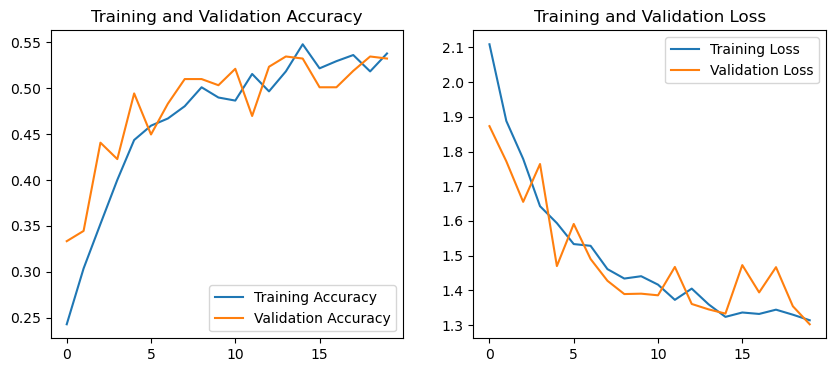

In [21]:
# Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Insights:
- Training Accuracy: The training accuracy gradually increased, starting from 21.34% in the first epoch and reaching 52.69% by the 20th epoch.
- Validation Accuracy: Validation accuracy fluctuated, with a peak at 53.47% in the 14th epoch and a final value of 53.24%.
- Training Loss: The training loss consistently decreased from 2.3592 to 1.3290, indicating better learning over time.
- Validation Loss: The validation loss showed fluctuations but generally decreased, reaching 1.3023 at the final epoch.


### Inferences:
Data Augmentation and Dropout seem to have helped stabilize the model’s learning process, as indicated by a steady improvement in training accuracy and loss.
The validation accuracy shows improvement, but it is still somewhat volatile, suggesting the model may need further fine-tuning to generalize better.

## Steps to Use Augmentor for Data Augmentation:

In [22]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [23]:
# Distribution of Original training data.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

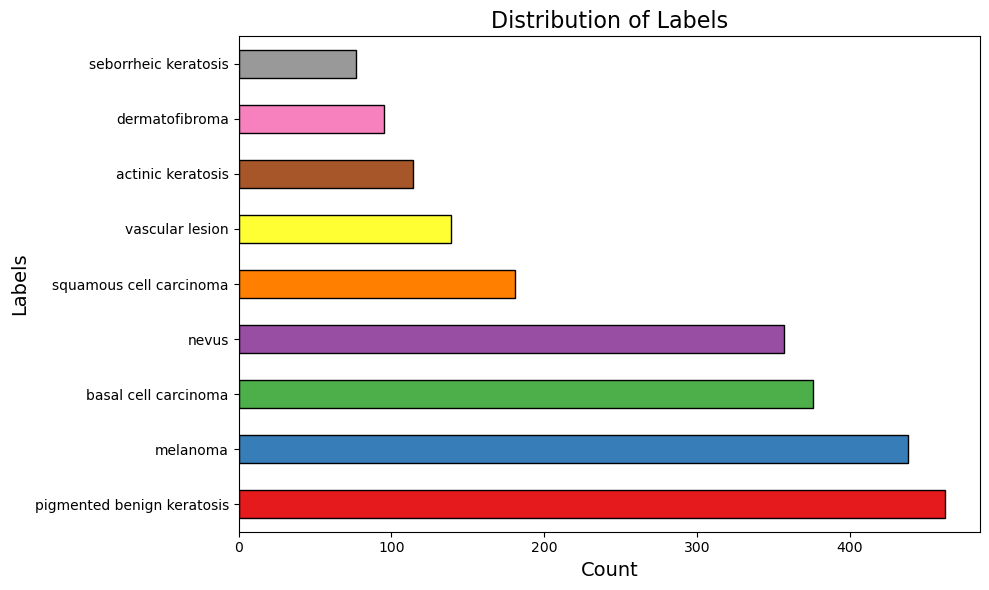

In [27]:
import seaborn as sns

label_counts = original_df['Label'].value_counts()

# Plot a bar chart
colors = sns.color_palette('Set1', len(label_counts))
plt.figure(figsize=(10, 6))
label_counts.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Distribution of Labels', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Labels', fontsize=14)
plt.tight_layout()
plt.show()

In [29]:
path_to_training_dataset= str(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Cancer_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x269BD10C9D0>: 100%|█| 500/500 [00:07<00:00, 64.79 Samples/


Initialised with 376 image(s) found.
Output directory set to Cancer_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26973C9DDD0>: 100%|█| 500/500 [00:07<00:00, 67.88 Samples/


Initialised with 95 image(s) found.
Output directory set to Cancer_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26973C67A50>: 100%|█| 500/500 [00:07<00:00, 65.09 Samples/


Initialised with 438 image(s) found.
Output directory set to Cancer_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x269BD402410>: 100%|█| 500/500 [00:45<00:00, 11.02 Samples


Initialised with 357 image(s) found.
Output directory set to Cancer_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x269BA3255D0>: 100%|█| 500/500 [00:44<00:00, 11.27 Samples/


Initialised with 462 image(s) found.
Output directory set to Cancer_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x269BD0F2850>: 100%|█| 500/500 [00:07<00:


Initialised with 77 image(s) found.
Output directory set to Cancer_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x269BDBD80D0>: 100%|█| 500/500 [00:19<00


Initialised with 181 image(s) found.
Output directory set to Cancer_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x269BD320990>: 100%|█| 500/500 [00:07<00:00, 63.68 Samples/


Initialised with 139 image(s) found.
Output directory set to Cancer_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x269BD412090>: 100%|█| 500/500 [00:07<00:


In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Cancer_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2860554e-f3b2-4c6e-bd7c-e373bae5d062.jpg',
 'Cancer_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6a90ee33-3161-40b6-957c-d72d1da9807a.jpg',
 'Cancer_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_df3fa521-69f6-449d-975c-7db07b67ef60.jpg',
 'Cancer_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_ec65da24-fbc9-41c5-ba9f-9ba8fe407d62.jpg',
 'Cancer_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_f3bfb7ad-552b-41bc-ad2f-a9ebf2082765.jpg',
 'Can

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [34]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [35]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [38]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [39]:
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

Now we are sure all teh classes have a min of 500 images

### Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [42]:
# Creating a training dataset and validation dataset
data_dir_train=data_dir_train#"Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode='categorical',
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model (make sure to include normalization

In [48]:
model = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),

    # Convolutional layer 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional layer 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional layer 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    # Flattening the feature map
    layers.Flatten(),

    # Fully connected layer 1
    layers.Dense(128, activation='relu'),
    # Dropout for regularization
    layers.Dropout(0.2),

    # Output layer with softmax activation
    layers.Dense(9, activation='softmax')
])


#### Compile your model (Choose optimizer and loss function appropriately)

In [49]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train your model

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [71]:
# ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
# So the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [77]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint,earlystop]
)

In [78]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel(epochs_range)
plt.legend(['Train', 'Validation'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel(epochs_range)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

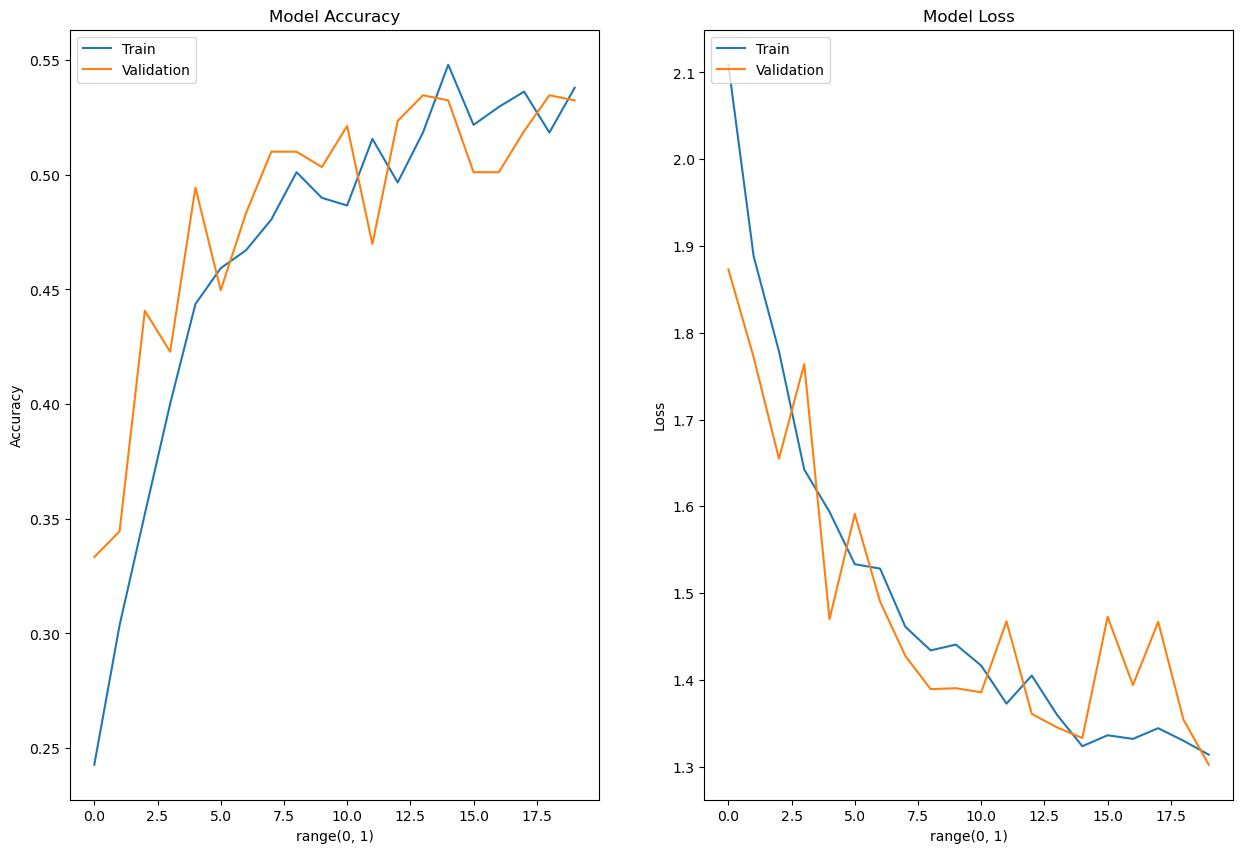

### Model Prediction

In [90]:
data_dir_test

WindowsPath('Cancer_data/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [102]:
class_names1

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


IndexError: list index out of range

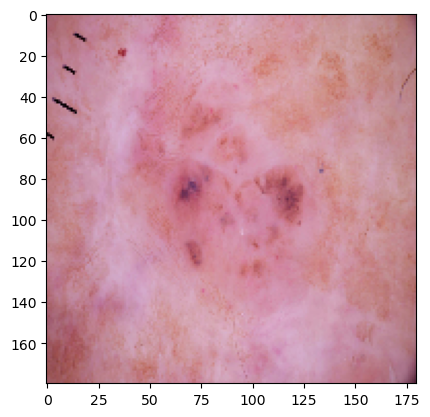

In [105]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )


In [106]:
import os
from glob import glob
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

# Debug the test directory and class names
print("Test Directory:", data_dir_test)
print("Exists:", os.path.exists(data_dir_test))
print("Class Names:", class_names)

# Define the test image path
Test_image_path = os.path.join(data_dir_test, class_names[1], '*.jpg')  # Adjust extension if needed
Test_image = glob(Test_image_path)
print("Found Images:", Test_image)

# Check if images are found
if not Test_image:
    print(f"No images found in path: {Test_image_path}")
else:
    # Load the last image
    Test_image = load_img(Test_image[-1], target_size=(180, 180, 3))
    plt.imshow(Test_image)
    plt.axis('off')
    plt.grid(False)
    plt.show()

    # Expand dimensions and predict
    img = np.expand_dims(Test_image, axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred)
    pred_class = class_names[pred]
    print("Actual Class: " + class_names[1] + '\n' + "Predictive Class: " + pred_class)


Test Directory: Cancer_data\Skin cancer ISIC The International Skin Imaging Collaboration\Test
Exists: True
Class Names: ['class_0', 'class_1', Ellipsis, 'class_N']
Found Images: []
No images found in path: Cancer_data\Skin cancer ISIC The International Skin Imaging Collaboration\Test\class_1\*.jpg


In [107]:
import os

train_folders = os.listdir(data_dir_train)
test_folders = os.listdir(data_dir_test)

print("Train Folders:", train_folders)
print("Test Folders:", test_folders)


Train Folders: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Test Folders: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Found Test Images: ['Cancer_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test\\basal cell carcinoma\\ISIC_0024331.jpg', 'Cancer_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test\\basal cell carcinoma\\ISIC_0024332.jpg', 'Cancer_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test\\basal cell carcinoma\\ISIC_0024345.jpg', 'Cancer_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test\\basal cell carcinoma\\ISIC_0024360.jpg', 'Cancer_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test\\basal cell carcinoma\\ISIC_0024403.jpg', 'Cancer_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test\\basal cell carcinoma\\ISIC_0024411.jpg', 'Cancer_data\\Skin cancer ISIC The Int

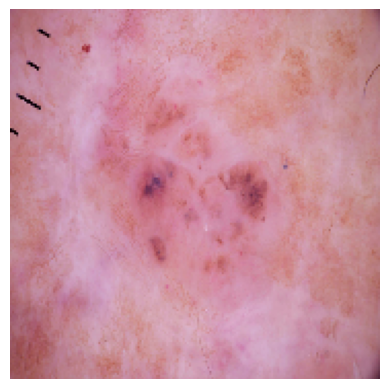

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


IndexError: list index out of range

In [109]:
# Ensure class names come from the training dataset
class_names = train_ds.class_names
print("Class Names:", class_names)

# Load and predict a test image
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')  # Match any file type
Test_image = glob(Test_image_path)
print("Found Test Images:", Test_image)

if Test_image:
    # Load the last image in the matched list
    Test_image = load_img(Test_image[-1], target_size=(180, 180, 3))
    plt.imshow(Test_image)
    plt.axis("off")
    plt.show()

    # Expand dimensions and predict
    img = np.expand_dims(Test_image, axis=0)
    pred = model.predict(img)
    pred_index = np.argmax(pred)
    pred_class = class_names[pred_index]  # Use training class names for mapping
    print("Actual Class:", class_names[1])
    print("Predicted Class:", pred_class)
else:
    print(f"No images found in path: {Test_image_path}")
